# Q5 - Smoke Status Recognition

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load the datasets
train_df = pd.read_excel('../Data_Q5/Q5_train.xlsx')
test_df = pd.read_csv('../Data_Q5/Q5_test.csv')

In [2]:
train_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165.0,60,81.0,0.5,0.6,1,1.0,135,...,40,75,16.5,1.0,1.0,22,25,27,0,1
1,1,70,165.0,65,89.0,0.6,0.7,2,2.0,146,...,57,126,16.2,1.0,1.1,27,23,37,1,0
2,2,20,170.0,75,81.0,0.4,0.5,1,1.0,118,...,45,93,17.4,1.0,0.8,27,31,53,0,1
3,3,35,180.0,95,105.0,1.5,1.2,1,1.0,131,...,38,102,15.9,1.0,1.0,20,27,30,1,0
4,4,30,165.0,60,80.5,1.5,1.0,1,1.0,121,...,44,93,15.4,1.0,0.8,19,13,17,0,1


In [3]:
test_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [4]:
# Data preprocessing
train_df.drop('id', axis=1, inplace=True)  # Drop the 'id' column

In [5]:
# Check for missing values
train_df.isnull().sum()

age                       0
height(cm)             9555
weight(kg)                0
waist(cm)                 8
eyesight(left)         9564
eyesight(right)           9
hearing(left)             0
hearing(right)         9555
systolic                  0
relaxation                0
fasting blood sugar       0
Cholesterol               0
triglyceride              0
HDL                       0
LDL                       0
hemoglobin                0
Urine protein          9587
serum creatinine          0
AST                       0
ALT                       0
Gtp                       0
dental caries             0
smoking                   0
dtype: int64

In [6]:
# Use average height to fill in the missing values
train_df['height(cm)'].fillna(train_df['height(cm)'].mean(), inplace=True)

# Use average waist to fill in the missing values
train_df['waist(cm)'].fillna(train_df['waist(cm)'].mean(), inplace=True)

# Use another eye to fill in the missing values
train_df['eyesight(left)'].fillna(train_df['eyesight(right)'], inplace=True)
train_df['eyesight(right)'].fillna(train_df['eyesight(left)'], inplace=True)

# Use another ear to fill in the missing values
train_df['hearing(right)'].fillna(train_df['hearing(left)'], inplace=True)

# Use average urine protein to fill in the missing values
train_df['Urine protein'].fillna(train_df['Urine protein'].mean(), inplace=True)

In [7]:
# Check for missing values
train_df.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [8]:
# Drop Duplicates
print(f'Shape before dropping duplicates: {train_df.shape}')
train_df.drop_duplicates(inplace=True)
print(f'Shape after dropping duplicates: {train_df.shape}')

Shape before dropping duplicates: (159256, 23)
Shape after dropping duplicates: (159256, 23)


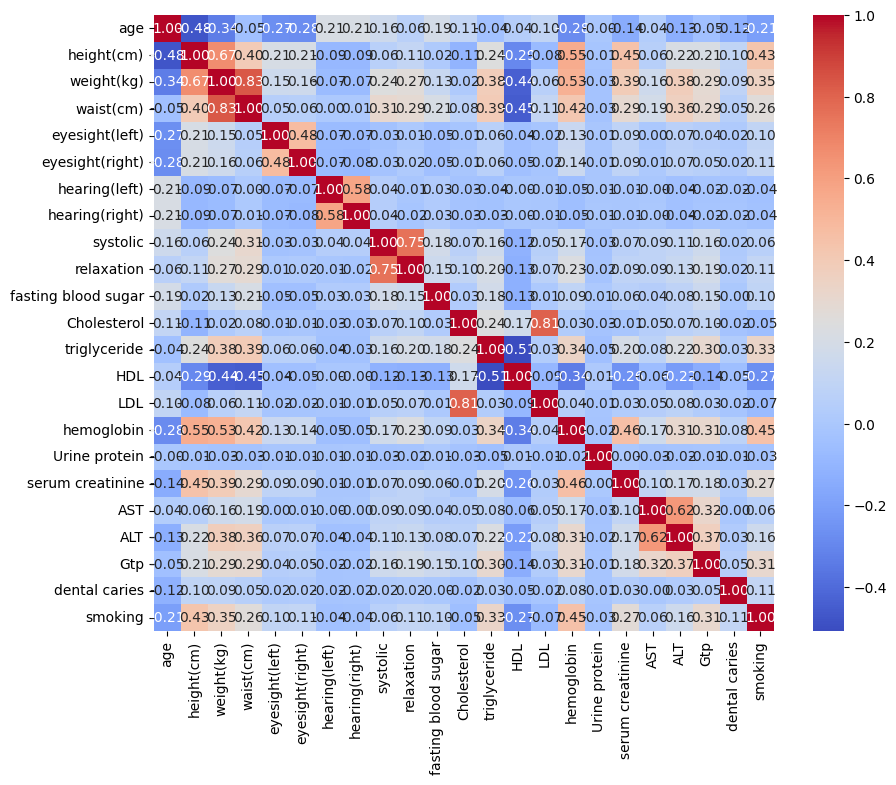

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = train_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.show()


In [10]:
best_model = None
best_auc = 0
scaler = StandardScaler()
X = scaler.fit_transform(train_df.drop('smoking', axis=1))
y = train_df['smoking']
X_test = scaler.transform(test_df.drop('id', axis=1))

kf = KFold(n_splits=10, shuffle=True, random_state=50015940)

In [11]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = LGBMClassifier(random_state=50015940, verbose=0)
    model.fit(X_train, y_train)

    val_predictions = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_predictions)
    print(f'Validation ROC Score: {val_auc}')
    print(f'BEST ROC Score: {best_auc}')

    if val_auc > best_auc:
        best_auc = val_auc
        best_model = model

Validation ROC Score: 0.862899295908313
BEST ROC Score: 0
Validation ROC Score: 0.8628233335273524
BEST ROC Score: 0.862899295908313
Validation ROC Score: 0.8624086168194984
BEST ROC Score: 0.862899295908313
Validation ROC Score: 0.8700809969733871
BEST ROC Score: 0.862899295908313
Validation ROC Score: 0.8658729199198454
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8640661489840153
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8654416798100414
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8632586726895297
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8620072700299117
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.863367368299281
BEST ROC Score: 0.8700809969733871


In [12]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostClassifier(random_state=50015940, verbose=0)
    model.fit(X_train, y_train)

    val_predictions = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_predictions)
    print(f'Validation ROC Score: {val_auc}')
    print(f'BEST ROC Score: {best_auc}')

    if val_auc > best_auc:
        best_auc = val_auc
        best_model = model

Validation ROC Score: 0.8672473862186428
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8675073250770073
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8668537580837085
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8755228561916721
BEST ROC Score: 0.8700809969733871
Validation ROC Score: 0.8694767722727569
BEST ROC Score: 0.8755228561916721
Validation ROC Score: 0.8682589421248335
BEST ROC Score: 0.8755228561916721
Validation ROC Score: 0.8697600122299483
BEST ROC Score: 0.8755228561916721
Validation ROC Score: 0.8674647067677526
BEST ROC Score: 0.8755228561916721
Validation ROC Score: 0.8670172165483092
BEST ROC Score: 0.8755228561916721
Validation ROC Score: 0.8668720515748672
BEST ROC Score: 0.8755228561916721


In [13]:
# Use the best model for prediction
test_predictions = best_model.predict_proba(X_test)[:, 1]

In [17]:
test_df['smoking'] = test_predictions

In [18]:
test_df

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,49,115,14.2,1,0.9,19,25,32,0,0.562997
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,35,104,13.0,1,1.1,20,12,24,0,0.359831
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,39,88,15.4,1,1.4,38,60,36,0,0.321709
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,75,128,14.5,1,0.6,25,18,10,1,0.021597
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,39,123,16.5,1,1.0,30,39,27,1,0.479763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,265422,40,165,60,78.0,0.8,0.9,1,1,112,...,59,149,16.4,1,1.1,24,31,28,0,0.626991
106167,265423,40,170,85,95.0,1.2,1.2,1,1,130,...,44,100,16.0,2,1.0,25,31,38,0,0.625857
106168,265424,35,170,85,89.0,1.2,1.2,1,1,131,...,53,142,15.9,1,0.8,33,32,24,1,0.483979
106169,265425,40,160,60,67.0,0.7,0.8,1,1,120,...,55,103,13.9,1,0.6,42,36,32,0,0.066995


In [19]:
test_df.to_csv('../Q5_output.csv', index=False)